This code is adapted from two sample notebooks https://github.com/planet-os/notebooks/blob/master/aws/era5-s3-via-boto.ipynb and https://github.com/pangeo-data/pangeo/blob/master/notebooks/newmann_ensemble_meteorology.ipynb


Using data downloaded from AWS ERA-5, we will utilize xarray and dask to plot and analyze variables.

ERA5 data is hourly at a gridded resolution of 30 km. ERA5 combines vast amounts of historical observations into global estimates using advanced modelling and data assimilation systems to provide estimates of large number of atmospheric, land and oceanic climate variables.

In [14]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display

In [ ]:
era5_bucket = 'era5-pds'
# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

Let's download main.nc file for the month indicated and use xarray to inspect the metadata relating to the data files.

In [3]:
date = datetime.date(2017,1,1) # update to desired date
prefix = date.strftime('%Y/%m/')

metadata_file = 'main.nc'
metadata_key = prefix + metadata_file
client.download_file(era5_bucket, metadata_key, metadata_file)
ds_meta = xr.open_dataset('main.nc', decode_times=False)
ds_meta.info()

xarray.Dataset {
dimensions:
	lat = 640 ;
	lat_ocean = 501 ;
	lon = 1280 ;
	lon_ocean = 1002 ;
	nv = 2 ;
	time0 = 744 ;
	time1 = 744 ;

variables:
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 time0(time0) ;
		time0:units = seconds since 1970-01-01 ;
		time0:standard_name = time ;
	float64 time1(time1) ;
		time1:units = seconds since 1970-01-01 ;
		time1:standard_name = time ;
		time1:bounds = time1_bounds ;
	float32 lat_ocean(lat_ocean) ;
		lat_ocean:standard_name = latitude ;
		lat_ocean:long_name = latitude ;
		lat_ocean:units = degrees_north ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	float32 lon_ocean(lon_ocean) ;
		lon_ocean:standard_name = longitude ;
		lon_ocean:long_name = longitude ;
		lon_ocean:units = degrees_east ;
	float32 air_temperature_at_2_metres(time0, lat, lon) ;
		air_temperature_at_2_metres:standard_name = air_temperatu

Change code to load 2 variables into 1 dataset

In [4]:
# select variable(s) of interest
var3 = 'air_temperature_at_2_metres'
var2 = 'air_pressure_at_mean_sea_level'
var = 'precipitation_amount_1hour_Accumulation'


# file path patterns for remote S3 objects and corresponding local file
s3_data_ptrn = '{year}/{month}/data/{var}.nc'
data_file_ptrn = '{year}{month}_{var}.nc'

year = date.strftime('%Y')
month = date.strftime('%m')
s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
data_file = data_file_ptrn.format(year=year, month=month, var=var)

if not os.path.isfile(data_file): # check if file already exists
    print("Downloading %s from S3..." % s3_data_key)
    client.download_file(era5_bucket, s3_data_key, data_file)

ds = xr.open_dataset(data_file)
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                                  (lat: 640, lon: 1280, nv: 2, time1: 744)
Coordinates:
  * lon                                      (lon) float32 0.0 ... 359.718
  * lat                                      (lat) float32 89.784874 ... -89.784874
  * time1                                    (time1) datetime64[ns] 2017-01-01T07:00:00 ... 2017-02-01T06:00:00
Dimensions without coordinates: nv
Data variables:
    time1_bounds                             (time1, nv) datetime64[ns] ...
    precipitation_amount_1hour_Accumulation  (time1, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        "ERA5 forecasts"
    history:      Thu Jul  5 04:04:23 2018: ncatted /data.e1/wrk/s3_out_in/20...>

## Spatial Subset to Western US

In [10]:
ds = ds.sel(lat=slice(50,10), lon=slice(360-140,360-105))

In [11]:
# calculates the monthly mean along the time dimension
da_mean = ds['precipitation_amount_1hour_Accumulation'].mean(dim='time1')

Text(0.5, 1.0, 'January 2017 Mean Precipitation')

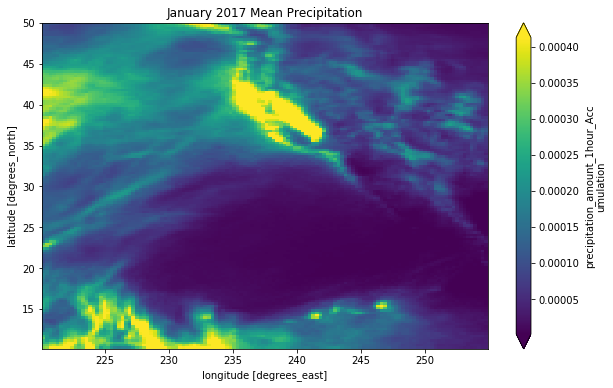

In [12]:
da_mean.plot(robust=True, figsize=(10, 6))
plt.title('January 2017 Mean Precipitation')

precip_mean_201701.png


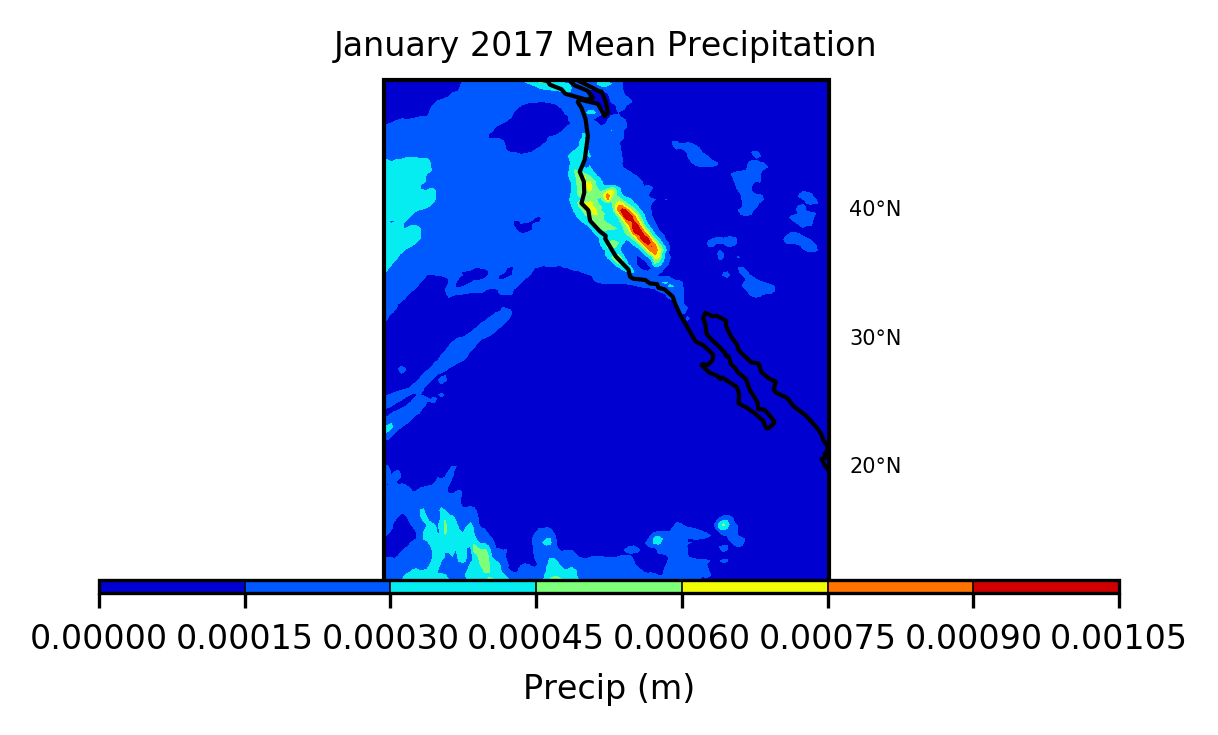

<Figure size 1200x675 with 0 Axes>

In [16]:
fig = plt.figure(figsize=(4.0 ,2.25))
fig.dpi = 300
fname = 'precip_mean_201701'
fmt = 'png'

results= da_mean

lats = ds.lat
lons = ds.lon

clevs = np.arange(9600,11100,100)

ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
# cf = ax.contourf(lons, lats, results, transform=ccrs.PlateCarree(), extend='both', cmap='jet', levels=clevs)
cf = ax.contourf(lons, lats, results, transform=ccrs.PlateCarree(), extend='neither', cmap='jet')

ax.coastlines()
plt.title('January 2017 Mean Precipitation', fontsize=8)

## Add in meridian and parallels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-20,-10, 10, 30, 50, 70, 90, 110, 120])
gl.ylocator = mticker.FixedLocator([0, 10, 20, 30, 40, 50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 5}
gl.ylabel_style = {'size': 5}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.09, 0.12, 0.85, 0.02])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='horizontal', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Precip (m)', fontsize=8)

plt.subplots_adjust(hspace=0.01)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

## Select Santa Barbara Gridpoint (34.4208° N, 119.6982° W) and plot time series

In [18]:
# location coordinates
locs = [
    {'name': 'santa_barbara', 'lon': -119.6982, 'lat': 34.4208},
    {'name': 'tallinn', 'lon': 24.753574, 'lat': 59.436962},
    {'name': 'honolulu', 'lon': -157.835938, 'lat': 21.290014},
    {'name': 'cape_town', 'lon': 18.423300, 'lat': -33.918861},
    {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'santa_barbara', 'lon': 240.30180000000001, 'lat': 34.4208},
 {'name': 'tallinn', 'lon': 24.753574, 'lat': 59.436962},
 {'name': 'honolulu', 'lon': 202.164062, 'lat': 21.290014},
 {'name': 'cape_town', 'lon': 18.4233, 'lat': -33.918861},
 {'name': 'dubai', 'lon': 55.316666, 'lat': 25.266666}]

In [19]:
ds_locs = xr.Dataset()

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({var : var_name}).drop(('lat', 'lon'))
    
    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    time1_bounds   (time1, nv) datetime64[ns] 2017-01-01T04:00:00 ... 2017-02-01T06:00:00
    santa_barbara  (time1) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tallinn        (time1) float32 1.3589859e-06 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    honolulu       (time1) float32 0.00060429424 0.00016425177 ... 0.0 0.0
    cape_town      (time1) float32 0.00018024445 0.0001077652 ... 4.2915344e-05
    dubai          (time1) float32 0.00040209293 0.0004042983 ... 0.0 0.0

In [21]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,santa_barbara,tallinn,honolulu,cape_town,dubai
count,1488.000000,1488.000000,1.488000e+03,1488.000000,1488.000000
mean,0.000274,0.000108,1.046962e-04,0.000333,0.000159
std,0.000780,0.000296,4.286939e-04,0.000929,0.000713
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,9.536743e-07,0.000020,0.000000
50%,0.000000,0.000008,1.416635e-05,0.000079,0.000003
75%,0.000093,0.000059,6.081397e-05,0.000246,0.000035
max,0.006563,0.002319,4.714560e-03,0.011721,0.009918


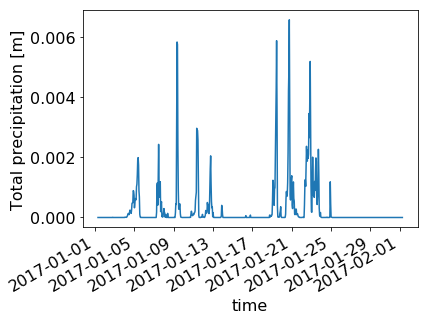

In [23]:
ds_locs.santa_barbara.plot()

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

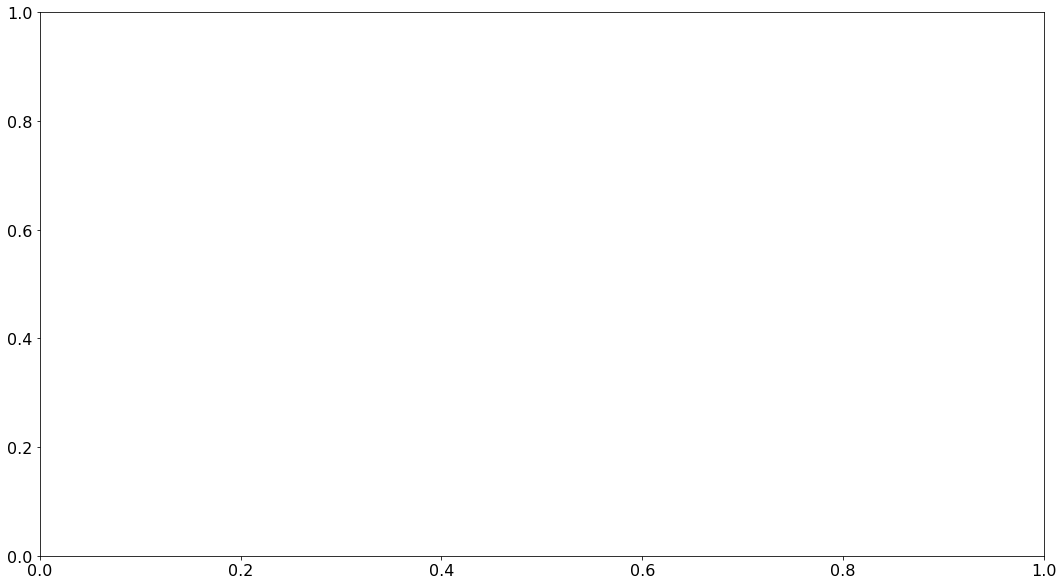

In [24]:
# readability please
plt.rcParams.update({'font.size': 16})

ax = df_f.plot.box(figsize=(18, 10))
ax.set(xlabel='Location', ylabel='Air Temperature (deg F)')
plt.show()